In [2]:
import sys
sys.version

'3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:09:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [1]:
# Example water vapor retrieval with ATMS sensor, using
#  ARTS OEM solver and principal components.
#
# Simon Pfreundschuh and David Duncan, Chalmers University

# Set up ARTS/Python environment


In [2]:
%env ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
%env ARTS_DATA_PATH=/home/simon/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simon/build/arts_production/arts/
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace()
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

env: ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
env: ARTS_DATA_PATH=/home/simon/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simon/build/arts_production/arts/
Loading ARTS API from: /home/simon/build/arts_production/arts/src/libarts_api.so
ARTS[45846688]: Executing /home/simon/src/arts_clean/controlfiles/general/general.arts
ARTS[45846688]: {
ARTS[45846688]: - verbosityInit
ARTS[45846688]: - scat_speciesSet
ARTS[45846688]: - MatrixSet
ARTS[45846688]: - Tensor4SetConstant
ARTS[45846688]: - ArrayOfStringSet
ARTS[45846688]: - Touch
ARTS[45846688]: - FlagOff
ARTS[45846688]: - MatrixSet
ARTS[45846688]: - NumericSet
ARTS[45846688]: - ArrayOfStringSet
ARTS[45846688]: - Tensor3SetConstant
ARTS[45846688]: - Tensor3SetConstant
ARTS[45846688]: - Tensor3SetConstant
ARTS[45846688]: - Tensor3SetConstant
ARTS[45846688]: - Tensor3SetConstant
ARTS[45846688]: - Tensor3SetConstant
ARTS[45846688]: - IndexSet
ARTS[45846688]: - IndexSet
ARTS[45846688]: - IndexSet
ARTS[45846688]: - IndexSet
ARTS[

In [3]:
# define absorbing species and sensor (here using metmm library, used again below)
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])
ws.ReadXML( ws.abs_lines, "instruments/metmm/abs_lines_metmm.xml.gz")
ws.abs_lines_per_speciesCreateFromLines()

# General Settings

In [4]:
ws.stokes_dim = 1
ws.iy_unit = "PlanckBT"
ws.cloudboxOff()

# Atmosphere set up

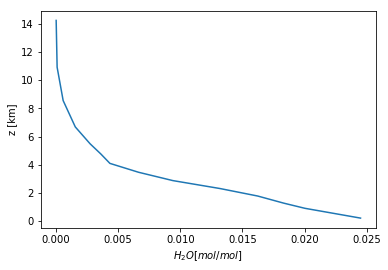

In [5]:
ws.atmosphere_dim = 1  # for 1DVAR
#ws.VectorNLogSpace( ws.p_grid, 20, 1e5, 1e4 ) # 20 levels from 1000 to 100 hPa
p = np.array([1000.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = 0.5 * (p[1:] + p[:-1])
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.AtmFieldsCalc()
ws.AbsInputFromAtmFields()

ws.z_surface = np.asarray(ws.z_field)[0]
ws.t_surface = np.asarray(ws.t_field)[0]

# plot T, water vapor, N2 and O2 versus altitude

#plt.plot(np.asarray(ws.t_field).ravel(), alt
alt = np.asarray(ws.z_field).ravel() * .001 # altitude in km (for plotting)
#plt.xlabel("T [K]")
#plt.ylabel("z [km]")
plt.plot(np.asarray(ws.vmr_field)[0,:,0,0], alt)
plt.xlabel("$H_2O [mol/mol$]")
plt.ylabel("z [km]")
#plt.plot(np.asarray(ws.vmr_field)[1,:,0,0], alt, label="$O_2$")
#plt.plot(np.asarray(ws.vmr_field)[2,:,0,0], alt, label="$N_2$")
#plt.xlabel("vmr [mol / mol]")
#plt.ylabel("z [km]")
#plt.legend()

# Sensor definition

In [6]:
ws.ArrayOfIndexCreate("channels")
ws.channels = [17,18,19,20,21] # channel index values given in metmm sensor description
ws.ArrayOfIndexCreate("viewing_angles")
ws.viewing_angles = [47] # index of stored viewing angles in metmm file

ws.sensor_pos  = np.array([[850e3]]) # 850km
ws.sensor_time = np.array([0.0])
ws.sensor_los  = np.array([[180.0]]) # nadir viewing

ws.IndexCreate("met_mm_accuracy") 
ws.met_mm_accuracy = 1 # points within each bandwidth to comute abs characteristics

ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_atms.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
ws.execute_controlfile("instruments/metmm/common_metmm.arts")

ARTS[45846688]: Executing /home/simon/src/arts_clean/controlfiles/instruments/metmm/sensor_descriptions/prepare_metmm.arts
ARTS[45846688]: {
ARTS[45846688]: - ArrayOfArrayOfIndexCreate
ARTS[45846688]: - ArrayOfIndexCreate
ARTS[45846688]: - VectorCreate
ARTS[45846688]: - ArrayOfIndexCreate
ARTS[45846688]: - NumericCreate
ARTS[45846688]: - VectorCreate
ARTS[45846688]: - IndexCreate
ARTS[45846688]: }

ARTS[45846688]: Executing /home/simon/src/arts_clean/controlfiles/instruments/metmm/sensor_descriptions/sensor_atms.arts
ARTS[45846688]: {
ARTS[45846688]: - MatrixSet
ARTS[45846688]: - MatrixSet
ARTS[45846688]: - ArrayOfStringSet
ARTS[45846688]: - VectorSet
ARTS[45846688]: - ArrayOfIndexSet
ARTS[45846688]: - VectorSet
ARTS[45846688]: - Extract
ARTS[45846688]: - nrowsGet
ARTS[45846688]: - VectorSetConstant
ARTS[45846688]: - Delete
ARTS[45846688]: }

ARTS[45846688]: Executing /home/simon/src/arts_clean/controlfiles/instruments/metmm/sensor_descriptions/apply_metmm.arts
ARTS[45846688]: {
ARTS[4

In [7]:
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.abs_xsec_agenda_checkedCalc()
ws.abs_lookupSetup()
ws.abs_lookupCalc()

# Surface 


In [8]:
ws.surface_scalar_reflectivity = np.array([0.5]) # nominal albedo for surface
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()
ws.jacobianOff()

# Call forward model

In [9]:
ws.yCalc()
ws.y.value # write out TBs for first ycalc

array([ 276.92856134,  270.37567794,  264.02072366,  256.46135151,
        249.86219702])

In [10]:
# now perturb the initial VMR field for water vapor
if not "orig_h2o" in globals().keys():
    orig_h2o = np.array(ws.vmr_field)[0,:,0,0] # save original WV profile (true state)
#np.asarray(ws.vmr_field)[0,:,0,0] = orig_h2o * 1.19 # perturb by x% at all layers
#perturbed = np.copy(ws.vmr_field)[0,:,0,0] # save as 'perturbed' -- will form apriori state



# Set up PCs for retrieval

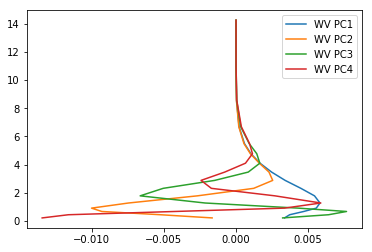

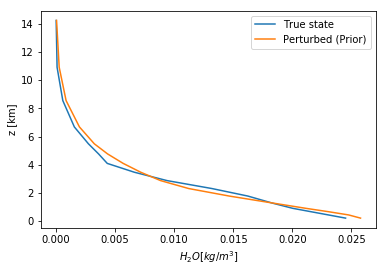

In [11]:
invar = np.loadtxt("pcs.txt") # read in PCs from ascii file
meanwv = np.array(invar[0:16][::-1]) # invert profiles to fit fwd model
A = np.transpose(invar[16:].reshape(6,16))
# convert WV mixing ratio (g/kg) to vmr (mol/mol)
factor = 28.966/18.016 * 0.001 

# PCs are in the wrong order, we go from the ground up
# Also need to take care that they are in c order instead
# of fortran order.
# We also limit numbr of PCs, seems like retrieval is not
# very well behaved...
n_pcs   = 4
PCs     = np.ascontiguousarray(A[::-1,:n_pcs] * factor)
meanwv *= factor

perturbed = meanwv # a priori state is mean profile of PCA
for i in range(n_pcs): # plot first x PCs
    plt.plot(PCs[:,i],alt,label="WV PC"+str(i+1))
plt.legend()

plt.figure()
plt.plot(orig_h2o.ravel(), alt, label="True state")
plt.plot(perturbed, alt, label="Perturbed (Prior)")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.legend()
plt.figure()

# Set up OEM retrieval

1


array([  2.50626377e-05,  -1.22741010e-04,   2.11559782e-04,
        -1.51199543e-04])

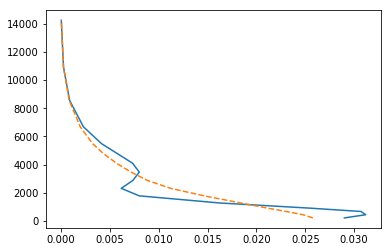

In [12]:
ws.retrievalDefInit()
print(1)
ws.retrievalAddAbsSpecies(   # only retrieval variable is abs species, water vapor
 species="H2O-PWR98",
 unit="vmr",
 g1=ws.p_grid,
 g2=ws.lat_grid,
 g3=ws.lon_grid
)
ws.transformationAdd(transformation_matrix=PCs, offset_vector=meanwv)
ws.covmatDiagonal(np.ones(n_pcs) * 1e-1)

# Constrain H_2O to be greater than ("gt") 0
ws.retrievalConstraintAdd(type="gt", limit=0.0)
# Add block for covariance matrix
ws.covmat_sxAddBlock(block=ws.covmat_block)

se_cov = np.zeros(ws.y.value.size) + 2.0**2 # set channel assumed errors
ws.covmatDiagonal(se_cov) # diagonal (uncorrelated) errors only for now
ws.covmat_seSet()
ws.retrievalDefClose()

# define inversion iteration as function object within python
@arts_agenda
def inversion_iterate_agenda(ws):
    ws.x2artsStandard()  # map x to ARTS's variables
    ws.atmfields_checkedCalc()  # to be safe, rerun checks dealing with atmosph.
    ws.atmgeom_checkedCalc()
    ws.yCalc()  # calculate yf and jacobian matching x
    ws.Print(ws.y)
    ws.Print(ws.jacobian)
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term
    ws.jacobianAdjustAfterIteration() 
    # last line takes care of some fixes needed to get the jacobian right for iterative solutions
    
ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda) # copy python function to arts
    
#ws.xaStandard() # set xa to vmr field, effectively 
ws.xa = np.zeros(n_pcs) # if supplying user-defined a priori vector
ws.x = np.array([]) # create empty vector for retrieved state vector?
ws.yf = np.array([]) # create empty vector for simulated TB?
ws.jacobian = np.array([[]])

ws.Copy(ws.x, ws.xa)
ws.x.value[2] = 1.0 
ws.x2artsStandard()
ws.xaStandard()
plt.plot( ws.vmr_field.value[0,:,:,:].ravel(), ws.z_field.value.ravel())
plt.plot(meanwv, ws.z_field.value.ravel(), ls="--")
meanwv = np.copy(meanwv)
meanwv.strides
ws.xa.value

# Run OEM retrieval

In [13]:
ws.OEM(method="gn",
    max_iter=1000,
    display_progress=1,
    max_start_cost=1e5,
    lm_ga_settings=np.array([10.0,2.0,2.0,1000000000000000000000000000.0,1.0,99.0])
       )
ws.x2artsStandard() # convert from ARTS coords back to user-defined grid

ARTS[45846688]: 
ARTS[45846688]:                                 MAP Computation                                
ARTS[45846688]: Formulation: Standard
ARTS[45846688]: Method:      Gauss-Newton
ARTS[45846688]: 
ARTS[45846688]:  Step     Total Cost         x-Cost         y-Cost    Conv. Crit.               
ARTS[45846688]: --------------------------------------------------------------------------------
ARTS[45846688]:     0        9.29791        1.99915        7.29875               
ARTS[45846688]:     1        3.64345       0.643975        2.99947        6.26585
ARTS[45846688]:     2        3.60574       0.857174        2.74857      0.0395482
ARTS[45846688]:     3        3.60449        0.89843        2.70606     0.00130405
ARTS[45846688]: --------------------------------------------------------------------------------
ARTS[45846688]: 
ARTS[45846688]: Total number of steps:            3
ARTS[45846688]: Final scaled cost function value: 3.60449
ARTS[45846688]: OEM computation converged.
A

In [14]:
# save resultant WV profile to 'retrieved'
retrieved = np.copy(ws.vmr_field)[0,:,0,0]
retrieved.min()
ws.oem_errors.print()
ws.x.value

ARTS[45846688]: 



array([-0.28747338, -0.2564862 , -0.39013339, -0.38546719])

# Look at results

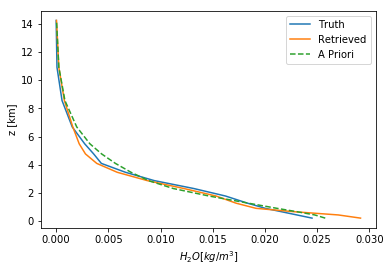

In [15]:
plt.plot(orig_h2o, alt, label="Truth")
plt.plot(retrieved, alt, label="Retrieved")
plt.plot(perturbed, alt, label="A Priori", ls="--")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
#plt.xscale("log")
plt.legend()

array([[  1.83450225e-04,  -1.58379055e-04,   2.50626377e-05,
         -5.57183059e-05],
       [ -1.58379055e-04,   2.96620218e-04,  -1.22741010e-04,
          3.06286470e-05],
       [  2.50626377e-05,  -1.22741010e-04,   2.11559782e-04,
         -1.51199543e-04],
       [ -5.57183059e-05,   3.06286470e-05,  -1.51199543e-04,
          3.98713724e-04]])

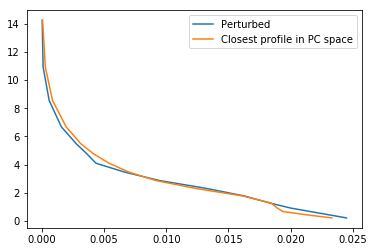

In [16]:
# The retrieval does not look very good but let's have a look
# if we can reach it att all
d_h2o = perturbed - orig_h2o
norm = np.dot(np.transpose(PCs), PCs)
components = np.dot(np.transpose(PCs), d_h2o) / norm.diagonal()
d_h2o_r = np.dot(PCs, components)
plt.plot(perturbed - d_h2o, alt, label="Perturbed")
plt.plot(perturbed - d_h2o_r, alt, label="Closest profile in PC space")
plt.legend()
norm

In [17]:
# compare simulated and 'observed' TB from 
residual = ws.y.value - ws.yf.value
residual 

array([ 0.05587012,  0.76956352,  1.87037361,  3.79681606,  5.96756108])

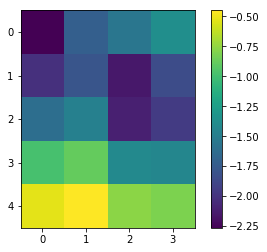

In [18]:
# plot jacobian -- should show sensitivity in middle troposphere
plt.imshow(ws.jacobian)
plt.colorbar()

0.5627596277711564

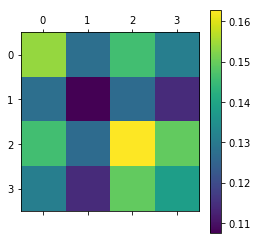

In [19]:
ws.avkCalc() # calculate averaging kernel (A-matrix)
plt.matshow(ws.avk)
plt.colorbar()
np.diag(ws.avk)
sum(np.diag(ws.avk)) # print trace of A-matrix, aka degrees of freedom for signal (DFS)

In [20]:
# calculate posterior covariance matrices of observations and a priori
ws.covmat_soCalc() # observation covariance matrix
ws.covmat_ssCalc() # smoothing covariance matrix

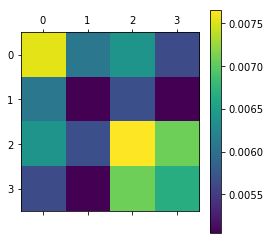

In [21]:
# plot posterior observation covariance matrix
plt.matshow(ws.covmat_so)
plt.colorbar()

In [22]:
ws.x.value

array([-0.28747338, -0.2564862 , -0.39013339, -0.38546719])